In [1]:
%matplotlib notebook
import numpy as np
import json, glob
import os, math
import pandas as pd
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
from IPython.display import clear_output, display
from datetime import datetime

from alvra_tools.load_data import *
from alvra_tools.channels import *
from alvra_tools.timing_tool import *
from alvra_tools.utils import *
from alvra_tools.YAG_scans import *
from ipyfilechooser import FileChooser

### Choose the json file:

In [2]:
fc = FileChooser('/sf/alvra/data/p19161/raw/scan_info/')
fc.use_dir_icons = True
display(fc)

FileChooser(path='/sf/alvra/data/p19161/raw/scan_info', filename='', show_hidden='False')

In [3]:
quantile_band = 0.5

channel_delay_motor = channel_delay_topas
timezero_mm = 210.42743877609544

targetM2 = 'YAG'
px2fsM2 = 2.2054

targetM1 = 'YAG'
px2fsM1 = 1.957

filterTimeM1 = 700
filterAmpM1 = 2
########################################
#YAG_scan_two_TT(json_file, channel_delay_motor, timezero_mm, quantile, 
#                    target_1, calibration_1, target_2, calibration_2,
#                    filterTime_1=2000, filterAmp_1=0, filterTime_2=2000, filterAmp_2=0):
########################################

Delay_fs, Delays_corr_M2, Delays_corr_M1, Pump_probe, Pump_probe_scan = \
YAG_scan_two_TT(fc.selected, channel_delay_motor, timezero_mm, quantile_band, targetM2, px2fsM2, targetM1, px2fsM1,\
                2000, 0, filterTimeM1, filterAmpM1)

pp_uncorrected = Pump_probe[:,0]
err_pp_low = Pump_probe[:,1]
err_pp_high = Pump_probe[:,2]

Processing: timescan_YAG_loop_1.json
Step 41 of 41: Processing run_001712
Pump rep rate (FEL) is 50.0 Hz
Probe rep rate (laser) is 100.0 Hz

--------------------------------------------------------------------------------

SAR-CVME-TIFALL5:EvtSet                     250 / 250 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M1.roi_signal_x_profile     250 / 250 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M2.roi_background_x_profile 250 / 250 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M2.roi_signal_x_profile     250 / 250 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SLAAR11-LMOT-M451:ENC_1_BS                  250 / 250 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SLAAR11-LSCP1-FNS:CH0:VAL_GET               250 / 250 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SLAAR11-LSCP1-FNS:CH2:VAL_GET               250 / 250 -> 0% loss ▇▇▇▇▇▇▇▇▇▇

over the whole data set: 250 / 250 -> 0% loss
complete channels: 7 / 7 -> 0% incomplete

--------------------------------------------------------------------------------

File recorded at 2021-05-06 02:24:13.638150
/sf/alvra/data/p19161/scratch

## Re-bin the data with chosen binsize

In [4]:
binsize = 10 # in fs

################################################################################################3
from scipy.stats import binned_statistic
print (np.shape(Pump_probe_scan),np.shape(Delays_corr_M2), np.shape(Delays_corr_M1))

binList = np.arange(Delay_fs[0] - 100, Delay_fs[-1] + 100, binsize)
Delay_fs_TT = np.arange(Delay_fs[0] -100 + binsize/2, Delay_fs[-1] + 100 - binsize/2, binsize)

pp_TT_M2, binEdges, binNumber = binned_statistic(Delays_corr_M2, Pump_probe_scan, statistic='mean', bins=binList)
pp_TT_M1, binEdges, binNumber = binned_statistic(Delays_corr_M1, Pump_probe_scan, statistic='mean', bins=binList)

(5094,) (5094,) (5094,)


## Choose fit function

In [5]:
# err function ---------------> [x0, amplitude, width, offset]
# exp_gauss_heaviside --------> [x0, amplitude, width, offset, lifetime]
# conv_exp_gauss_heaviside2 --> [x0, amplitude, width, offset, lifetime, a, b]

fit = Fit(errfunc_fwhm, estimate_errfunc_parameters)
# fit = Fit(conv_exp_gauss_heaviside, estimate_conv_exp_gauss_heaviside_parameters) 
# fit = Fit(conv_exp_gauss_heaviside2, estimate_conv_exp_gauss_heaviside2_parameters)

## Do the fit for the first TT

In [6]:
index_M2 = ~(np.isnan(Delay_fs_TT) | np.isnan(pp_TT_M2))
Delay_fs_TT_M2 = Delay_fs_TT[index_M2]
pp_TT_M2 =  pp_TT_M2[index_M2]

fit.estimate(Delay_fs_TT_M2, pp_TT_M2)            # this sets some internal params 

#fit.p0 = better_p0(fit.p0, 0, 210.42) # overwrite some values (index) if needed: 

fit.fit(Delay_fs_TT_M2,pp_TT_M2)                  # calculate the fit
pp_fit_M2 = fit.eval(Delay_fs_TT_M2)           # evaluate the curve for plotting

t0_fs_M2 = fit.popt[0]
t0_mm_M2 = timezero_mm + fs2mm(t0_fs_M2, 0)
width_fs_M2 = fit.popt[2]

## Do the fit for the second TT

In [7]:
index_M1 = ~(np.isnan(Delay_fs_TT) | np.isnan(pp_TT_M1))
Delay_fs_TT_M1 = Delay_fs_TT[index_M1]
pp_TT_M1 =  pp_TT_M1[index_M1]

fit.estimate(Delay_fs_TT_M1, pp_TT_M1)            # this sets some internal params 

#fit.p0 = better_p0(fit.p0, 0, 210.42) # overwrite some values (index) if needed: 

fit.fit(Delay_fs_TT_M1,pp_TT_M1)                  # calculate the fit
pp_fit_M1 = fit.eval(Delay_fs_TT_M1)           # evaluate the curve for plotting

t0_fs_M1 = fit.popt[0]
t0_mm_M1 = timezero_mm + fs2mm(t0_fs_M1, 0)
width_fs_M1 = fit.popt[2]

## Plot

<IPython.core.display.Javascript object>


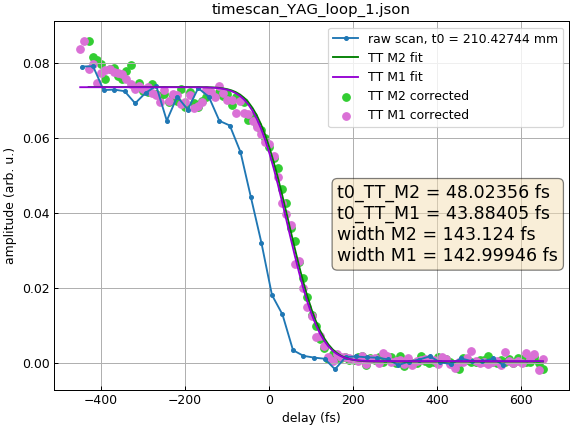

In [8]:
fig, ax = plt.subplots(constrained_layout=True)
#plt.figure(constrained_layout=True)
plt.title(fc.selected_filename)
plt.tick_params(direction='in')

#plt.plot(Delays_corr, Pump_probe_scan, 'o', color='lightblue')
plt.plot(Delay_fs, pp_uncorrected, marker='.',label = 'raw scan, t0 = {} mm'.format((np.round(timezero_mm, 5))))
plt.scatter(Delay_fs_TT_M2, pp_TT_M2, color='limegreen', label = 'TT M2 corrected')
plt.scatter(Delay_fs_TT_M1, pp_TT_M1, color='orchid', label = 'TT M1 corrected')
plt.plot(Delay_fs_TT_M2, pp_fit_M2, color='green', label = 'TT M2 fit')
plt.plot(Delay_fs_TT_M1, pp_fit_M1, color='darkviolet', label = 'TT M1 fit')


boxstyle = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
boxtext = '\n'.join((r't0_TT_M2 = {} fs'.format(np.round(t0_fs_M2, 5)),
                     r't0_TT_M1 = {} fs'.format(np.round(t0_fs_M1, 5)),
            r'width M2 = {} fs'.format(np.abs(np.round(width_fs_M2, decimals = 5))),
            r'width M1 = {} fs'.format(np.abs(np.round(width_fs_M1, decimals = 5)))))
plt.text(0.55, 0.35, boxtext, transform=ax.transAxes, bbox=boxstyle, fontsize=14)

plt.xlabel('delay (fs)')
plt.ylabel('amplitude (arb. u.)')
plt.legend (loc = 'upper right')
plt.grid()
plt.show()


# Loop over several runs

In [11]:
datafiles = []
for file in glob('/sf/alvra/data/p19161/raw/scan_info/timescan_YAG_loop_*.json'):
    datafiles.append(file)
datafiles = sorted(datafiles, key = os.path.getmtime)
patch = datafiles[:90]
patch

['/sf/alvra/data/p19161/raw/scan_info/timescan_YAG_loop_1.json',
 '/sf/alvra/data/p19161/raw/scan_info/timescan_YAG_loop_2.json',
 '/sf/alvra/data/p19161/raw/scan_info/timescan_YAG_loop_3.json',
 '/sf/alvra/data/p19161/raw/scan_info/timescan_YAG_loop_4.json',
 '/sf/alvra/data/p19161/raw/scan_info/timescan_YAG_loop_5.json',
 '/sf/alvra/data/p19161/raw/scan_info/timescan_YAG_loop_6.json',
 '/sf/alvra/data/p19161/raw/scan_info/timescan_YAG_loop_7.json',
 '/sf/alvra/data/p19161/raw/scan_info/timescan_YAG_loop_8.json',
 '/sf/alvra/data/p19161/raw/scan_info/timescan_YAG_loop_9.json',
 '/sf/alvra/data/p19161/raw/scan_info/timescan_YAG_loop_10.json',
 '/sf/alvra/data/p19161/raw/scan_info/timescan_YAG_loop_11.json',
 '/sf/alvra/data/p19161/raw/scan_info/timescan_YAG_loop_12.json',
 '/sf/alvra/data/p19161/raw/scan_info/timescan_YAG_loop_13.json',
 '/sf/alvra/data/p19161/raw/scan_info/timescan_YAG_loop_14.json',
 '/sf/alvra/data/p19161/raw/scan_info/timescan_YAG_loop_15.json',
 '/sf/alvra/data/p1

In [13]:
quantile_band = 0.5
binsize = 10

channel_delay_motor = channel_delay_topas
timezero_mm = 210.42743877609544

targetM2 = 'YAG'
px2fsM2 = 2.2054

targetM1 = 'YAG'
px2fsM1 = 1.957

filterTimeM1 = 700
filterAmpM1 = 2

########################################################################
from sfdata import SFScanInfo
from scipy.stats import binned_statistic

t0_fs_M2_scan =[]
width_fs_M2_scan = []
t0_fs_M1_scan =[]
width_fs_M1_scan = []

for json_file in patch:
    print (json_file)
    scan = SFScanInfo(json_file)
    
    Delay_fs, Delays_corr_M2, Delays_corr_M1, Pump_probe, Pump_probe_scan = \
    YAG_scan_two_TT(json_file, channel_delay_motor, timezero_mm, quantile_band, \
                    targetM2, px2fsM2, targetM1, px2fsM1, \
                    2000, 0, filterTimeM1, filterAmpM1)
    
    print (np.shape(Pump_probe_scan),np.shape(Delays_corr_M2), np.shape(Delays_corr_M1))

    binList = np.arange(Delay_fs[0] - 100, Delay_fs[-1] + 100, binsize)
    Delay_fs_TT = np.arange(Delay_fs[0] -100 + binsize/2, Delay_fs[-1] + 100 - binsize/2, binsize)

    pp_TT_M2, binEdges, binNumber = binned_statistic(Delays_corr_M2, Pump_probe_scan, statistic='mean', bins=binList)
    pp_TT_M1, binEdges, binNumber = binned_statistic(Delays_corr_M1, Pump_probe_scan, statistic='mean', bins=binList)

    fit = Fit(errfunc_fwhm, estimate_errfunc_parameters)
    # fit = Fit(conv_exp_gauss_heaviside, estimate_conv_exp_gauss_heaviside_parameters) 
    # fit = Fit(conv_exp_gauss_heaviside2, estimate_conv_exp_gauss_heaviside2_parameters)
    
    index_M2 = ~(np.isnan(Delay_fs_TT) | np.isnan(pp_TT_M2))
    index_M1 = ~(np.isnan(Delay_fs_TT) | np.isnan(pp_TT_M1))

    Delay_fs_TT_M2 = Delay_fs_TT[index_M2]
    Delay_fs_TT_M1 = Delay_fs_TT[index_M1]
    pp_TT_M2 =  pp_TT_M2[index_M2]
    pp_TT_M1 =  pp_TT_M1[index_M1]
    
    ############################################################

    fit.estimate(Delay_fs_TT_M2, pp_TT_M2)            # this sets some internal params 

    #fit.p0 = better_p0(fit.p0, 0, 210.42) # overwrite some values (index) if needed: 

    fit.fit(Delay_fs_TT_M2,pp_TT_M2)                  # calculate the fit
    pp_fit_M2 = fit.eval(Delay_fs_TT_M2)           # evaluate the curve for plotting
    
    t0_fs_M2 = fit.popt[0]
    width_fs_M2 = fit.popt[2]
    
    ############################################################
    
    fit.estimate(Delay_fs_TT_M1, pp_TT_M1)            # this sets some internal params 

    #fit.p0 = better_p0(fit.p0, 0, 210.42) # overwrite some values (index) if needed: 

    fit.fit(Delay_fs_TT_M1,pp_TT_M1)                  # calculate the fit
    pp_fit_M1 = fit.eval(Delay_fs_TT_M1)           # evaluate the curve for plotting
    
    t0_fs_M1 = fit.popt[0]
    width_fs_M1 = fit.popt[2]
    
    ############################################################
    
    t0_fs_M2_scan.append(t0_fs_M2)
    width_fs_M2_scan.append(width_fs_M2)
    t0_fs_M1_scan.append(t0_fs_M1)
    width_fs_M1_scan.append(width_fs_M1)

Processing: timescan_YAG_loop_90.json
Step 41 of 41: Processing run_005361
Pump rep rate (FEL) is 50.0 Hz
Probe rep rate (laser) is 100.0 Hz

--------------------------------------------------------------------------------

SAR-CVME-TIFALL5:EvtSet                     251 / 251 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M1.roi_signal_x_profile     251 / 251 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M2.roi_background_x_profile 251 / 251 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M2.roi_signal_x_profile     251 / 251 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SLAAR11-LMOT-M451:ENC_1_BS                  251 / 251 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SLAAR11-LSCP1-FNS:CH0:VAL_GET               251 / 251 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SLAAR11-LSCP1-FNS:CH2:VAL_GET               251 / 251 -> 0% loss ▇▇▇▇▇▇▇▇▇▇

over the whole data set: 251 / 251 -> 0% loss
complete channels: 7 / 7 -> 0% incomplete

--------------------------------------------------------------------------------

File recorded at 2021-05-06 05:27:26.181565
/sf/alvra/data/p19161/scratc

<IPython.core.display.Javascript object>


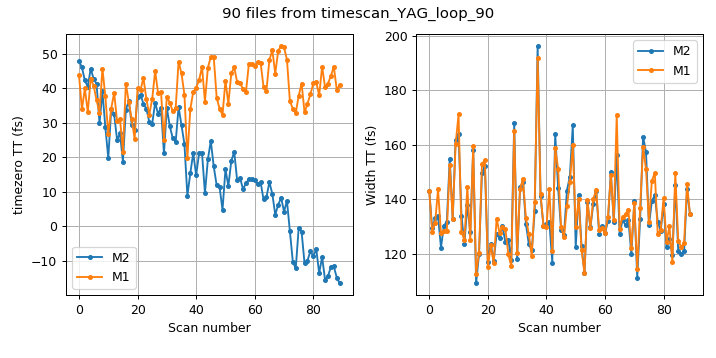

In [14]:
plt.figure(figsize = (8,4))
plt.suptitle ('{} files from {}'.format(len(patch), json_file.split('/')[-1].split('.')[0]))

plt.subplot(121)
plt.plot(t0_fs_M2_scan, marker='.', label='M2')
plt.plot(t0_fs_M1_scan, marker='.', label='M1')
plt.legend(loc='best')
plt.xlabel('Scan number')
plt.ylabel('timezero TT (fs)')
plt.grid()

plt.subplot(122)
plt.plot(width_fs_M2_scan, marker='.', label='M2')
plt.plot(width_fs_M1_scan, marker='.', label='M1')
plt.legend(loc='best')
plt.xlabel("Scan number")
plt.ylabel('Width TT (fs)')
plt.grid()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

##  Timing tool traces & statistics

In [2]:
fc = FileChooser('/sf/alvra/data/p19161/raw/scan_info/')
fc.use_dir_icons = True
display(fc)

FileChooser(path='/sf/alvra/data/p19161/raw/scan_info', filename='', show_hidden='False')

In [3]:
targetM2 = 'YAG'
px2fsM2 = 2.2054

targetM1 = 'YAG'
px2fsM1 = 1.957

arrTimes_M2, arrTimesAmp_M2, arrTimes_M2_scan, arrTimesAmp_M2_scan, peaktraces_M2,\
arrTimes_M1, arrTimesAmp_M1, arrTimes_M1_scan, arrTimesAmp_M1_scan, peaktraces_M1 = \
Two_TT_statistics_scan(fc.selected,  targetM2, px2fsM2, targetM1, px2fsM1)


Processing: timescan_YAG_loop_22.json
Step 41 of 41: Processing run_002573
Pump rep rate (FEL) is 50.0 Hz
Probe rep rate (laser) is 100.0 Hz

--------------------------------------------------------------------------------

SAR-CVME-TIFALL5:EvtSet                     250 / 250 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M1.roi_signal_x_profile     250 / 250 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M2.roi_background_x_profile 250 / 250 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M2.roi_signal_x_profile     250 / 250 -> 0% loss ▇▇▇▇▇▇▇▇▇▇

over the whole data set: 250 / 250 -> 0% loss
complete channels: 4 / 4 -> 0% incomplete

--------------------------------------------------------------------------------

File recorded at 2021-05-06 03:07:38.097397
/sf/alvra/data/p19161/scratch/2021-05-07-13:02-psen-background.txt
/sf/alvra/data/p19161/scratch/2021-05-07-13:02-psen-peak-background.txt


<IPython.core.display.Javascript object>


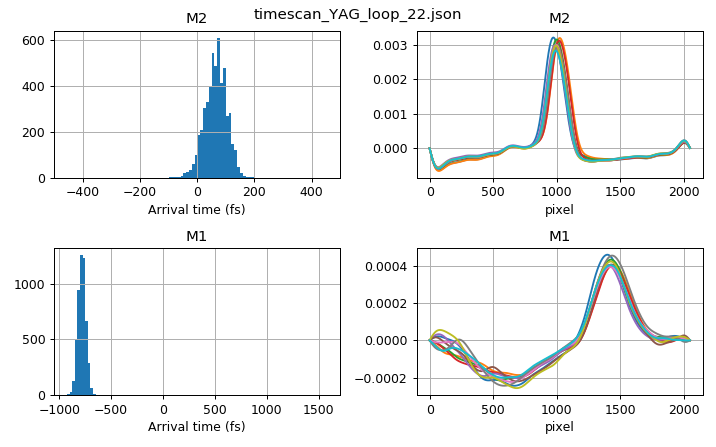

M2
Statistics on all (5106,) shots of the scan
Offset compared to pixel 1048 is 65.34652894633764 fs
Jitter, i.e. width (std) of the histogram 37.830723822592574 fs
--------------------------------------------------------------
Statistics on (125,) shots of the last step of the scan
Offset compared to pixel 1048 is 53.95290560000001 fs
Jitter, i.e. width (std) of the histogram 37.451348265606256 fs
**************************************************************
M1
Statistics on all (5106,) shots of the scan
Offset compared to pixel 1048 is -781.105159811986 fs
Jitter, i.e. width (std) of the histogram 49.8186706454013 fs
--------------------------------------------------------------
Statistics on (125,) shots of the last step of the scan
Offset compared to pixel 1048 is -784.2246960000001 fs
Jitter, i.e. width (std) of the histogram 36.40177903327781 fs


In [10]:
plt.figure(figsize = (8,5))
plt.suptitle (fc.selected_filename)

plt.subplot(221)
plt.title('M2')
plt.hist(arrTimes_M2_scan, bins=30)
plt.grid()
plt.xlim(-500,500)
plt.xlabel('Arrival time (fs)')

plt.subplot(222)
plt.title('M2')
for i in range(10):
   # plt.plot(sigtraces[i][200:1500])
    #plt.plot(pixelNum[100:2047], sigtraces[i][0:1947])
    plt.plot(peaktraces_M2[i])#*10000)
plt.xlabel ('pixel')
#plt.xlim(500,1500)
plt.grid()

plt.subplot(223)
plt.title('M1')
plt.hist(arrTimes_M1_scan, bins=100)
plt.grid()
#plt.xlim(-1000,0)
plt.xlabel('Arrival time (fs)')

plt.subplot(224)
plt.title('M1')
for i in range(10):
   # plt.plot(sigtraces[i][200:1500])
    #plt.plot(pixelNum[100:2047], sigtraces[i][0:1947])
    plt.plot(peaktraces_M1[i])#*10000)
plt.xlabel ('pixel')
#plt.xlim(500,1500)
plt.grid()

plt.tight_layout()
plt.show()

print("M2")
print("Statistics on all {} shots of the scan".format(np.shape(arrTimes_M2_scan)))
print("Offset compared to pixel 1048 is {} fs".format(np.mean(arrTimes_M2_scan)))
print("Jitter, i.e. width (std) of the histogram {} fs".format(np.std(arrTimes_M2_scan)))
print("--------------------------------------------------------------")
print("Statistics on {} shots of the last step of the scan".format(np.shape(arrTimes_M2)))
print("Offset compared to pixel 1048 is {} fs".format(np.mean(arrTimes_M2)))
print("Jitter, i.e. width (std) of the histogram {} fs".format(np.std(arrTimes_M2)))
print("**************************************************************")
print("M1")
print("Statistics on all {} shots of the scan".format(np.shape(arrTimes_M1_scan)))
print("Offset compared to pixel 1048 is {} fs".format(np.mean(arrTimes_M1_scan)))
print("Jitter, i.e. width (std) of the histogram {} fs".format(np.std(arrTimes_M1_scan)))
print("--------------------------------------------------------------")
print("Statistics on {} shots of the last step of the scan".format(np.shape(arrTimes_M1)))
print("Offset compared to pixel 1048 is {} fs".format(np.mean(arrTimes_M1)))
print("Jitter, i.e. width (std) of the histogram {} fs".format(np.std(arrTimes_M1)))
